In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
from scipy.stats import ttest_ind
from scipy.stats import pearsonr


In [157]:
# Load the dataset
df = pd.read_csv('London_Listings.csv')

# Original shape
print('Original Shape:', df.shape)

# First 5 rows
df.head()

Original Shape: (66679, 31)


,id,name,description,host_id,host_name,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,amenities,price,minimum_nights,maximum_nights,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,calculated_host_listings_count
0,2.763150e+07,1,NaN,35877912,Alex,15/06/2015,NaN,NaN,f,1.0,...,"[""Kitchen"", ""Refrigerator"", ""Microwave"", ""Free...",$200.00,1,1125,14/06/2024,0,NaN,NaN,NaN,1
1,1.100000e+18,1,Get comfortable and enjoy plenty of extra room...,564055882,Lili-Ann,26/02/2024,NaN,NaN,f,1.0,...,[],$675.00,1,365,15/06/2024,0,NaN,NaN,NaN,1
2,1.170000e+18,117,Keep it simple at this peaceful and centrally-...,528033284,Shujauddin,26/07/2023,86%,50%,f,2.0,...,"[""Washer"", ""Wifi"", ""Kitchen""]",$95.00,1,365,16/06/2024,0,NaN,NaN,NaN,2
3,8.730000e+17,- Bright Central London Apartment -,My apartment has everything you possibly need ...,99268099,Alex,11/10/2016,98%,93%,t,5.0,...,"[""Microwave"", ""Hot water kettle"", ""Body soap"",...",$166.00,7,365,16/06/2024,24,24/04/2023,02/05/2024,4.83,1
4,4.672403e+07,""" Bright & Cosy Loft apartment """,Lovely and cosy arctic space with a separate d...,359199241,Karol,29/07/2020,100%,95%,t,1.0,...,"[""Cleaning products"", ""Cooking basics"", ""First...",$105.00,2,60,14/06/2024,46,20/08/2021,02/06/2024,4.89,1


In [158]:
# Check types before categorising
print(df.dtypes)

id                                float64
name                               object
description                        object
host_id                             int64
host_name                          object
host_since                         object
host_response_rate                 object
host_acceptance_rate               object
host_is_superhost                  object
host_listings_count               float64
host_total_listings_count         float64
neighbourhood                      object
latitude                          float64
longitude                         float64
property_type                      object
room_type                          object
accommodates                        int64
bathrooms                         float64
bathrooms_text                     object
bedrooms                          float64
beds                              float64
amenities                          object
price                              object
minimum_nights                    

In [159]:
# Organise the coluns in categorical and numerical types
categorical_var = df.select_dtypes(include=['object']).columns.tolist()
numerical_var = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical Variables:", categorical_var)
print("Numerical Variables:", numerical_var)

Categorical Variables: ['name', 'description', 'host_name', 'host_since', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'neighbourhood', 'property_type', 'room_type', 'bathrooms_text', 'amenities', 'price', 'calendar_last_scraped', 'first_review', 'last_review']
Numerical Variables: ['id', 'host_id', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'calculated_host_listings_count']


In [160]:
# Count unique rows with at least one missing value
unique_missing_rows_before = df.isnull().any(axis=1).sum()

# Calculate the percentage of the dataset that has missing values
total_rows = df.shape[0]
percentage_missing = (unique_missing_rows_before / total_rows) * 100

# Print results
print(f"Total unique rows with missing values: {unique_missing_rows_before}")
print(f"Percentage of dataset with missing values: {percentage_missing:.2f}%")

Total unique rows with missing values: 24805
Percentage of dataset with missing values: 37.20%


In [161]:
# Fix the price column by removing $ sign and commas.
df['price'] = df['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Create a copy of the untouched dataset so we can compare to the data cleaning later.
df_first = df.copy()

# Remove listings with zero or negative prices
df = df[df['price'] > 0]
print(df['price'].describe())

# Drop rows where 'price' is NaN since it is a target variable. (Important one)
df.dropna(subset=['price'], inplace=True) # 61418
print("Shape after removing empty `price` rows:", df.shape)

# 3 properties of 80000.00, 1 propert of 1.00

count    61417.000000
mean       209.990621
std        961.458327
min          1.000000
25%         78.000000
50%        138.000000
75%        227.000000
max      80000.000000
Name: price, dtype: float64
Shape after removing empty `price` rows: (61417, 31)


In [162]:
# Categorical variables, remove empty strings or lists and replace with Nan.
for col in categorical_var:
    df[col] = df[col].replace(['', '[]'], np.nan)
    
missing_col_val = df.isnull().sum()
print('Missing column values:\n', missing_col_val[missing_col_val > 0])

Missing column values:
 description                   1870
host_name                        1
host_since                       1
host_response_rate            6615
host_acceptance_rate          4365
host_is_superhost              370
host_listings_count              1
host_total_listings_count        1
bathrooms                       69
bathrooms_text                 100
bedrooms                       101
beds                           140
amenities                      132
first_review                 14736
last_review                  14736
review_scores_rating         14736
dtype: int64


In [163]:
# Drop unnecessary columns, as they are either replaced or are useless in the model building.
drop_columns = ['host_name', 'calendar_last_scraped', 'bathrooms_text', 'latitude', 'longitude', 'first_review', 'last_review', 'id' ]
df.drop(columns=drop_columns, inplace=True, errors='ignore')

# Updated shape
print("Shape after dropping unnecessary columns:", df.shape)

Shape after dropping unnecessary columns: (61417, 23)


In [164]:
# Fill missing values with median as it's the safest and least aggresive approach of thinning our dataset size
df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
df['bedrooms'].fillna(df['bedrooms'].median(), inplace=True)
df['beds'].fillna(df['beds'].median(), inplace=True)

# Updated shape
print('Shape after dropping duplicates and NaN rows:', df.shape)

Shape after dropping duplicates and NaN rows: (61417, 23)


In [165]:
# Count duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 52


In [166]:
# Drop duplicate rows since the number of duplicates is low compared to our dataset size
df.drop_duplicates(inplace=True)
# Check the new shape
print("Shape after dropping duplicates:", df.shape)

Shape after dropping duplicates: (61365, 23)


In [167]:
# Count rows where number_of_reviews is 0 and review_scores_rating is NaN
zero_reviews_missing_rating = df[(df['number_of_reviews'] == 0) & (df['review_scores_rating'].isnull())]

print(f"Listings with 0 reviews and missing rating: {zero_reviews_missing_rating.shape[0]}")
print(f"Total missing review_scores_rating: {df['review_scores_rating'].isnull().sum()}")


Listings with 0 reviews and missing rating: 14685
Total missing review_scores_rating: 14685


In [168]:
# Fill missing review scores with 0 (indicating that there have no reviews)
df.loc[df['number_of_reviews'] == 0, 'review_scores_rating'] = 0

# Check if missing values remain
print("Missing values after fixing review_scores_rating:", df['review_scores_rating'].isnull().sum())

Missing values after fixing review_scores_rating: 0


In [169]:
# Fill missing columns
df['amenities'].fillna("Unknown", inplace=True)
df['description'].fillna("No description", inplace=True)

# Convert response & acceptance rate to numeric by removing % and diving by 100
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '').astype(float) / 100
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%', '').astype(float) / 100

# Fill missing values with median
df['host_response_rate'].fillna(df['host_response_rate'].median(), inplace=True)
df['host_acceptance_rate'].fillna(df['host_acceptance_rate'].median(), inplace=True)

# Convert 'host_is_superhost' to binary (t → 1, f → 0)
df['host_is_superhost'] = df['host_is_superhost'].map({'t': 1, 'f': 0})
df['host_is_superhost'].fillna(0, inplace=True)  # Assuming that missing → not superhost

# Check if missing values remain
print("Missing values after handling host columns:\n", df.isnull().sum()[df.isnull().sum() > 0])

Missing values after handling host columns:
 host_since                   1
host_listings_count          1
host_total_listings_count    1
dtype: int64


In [170]:
# Drop rows where values of the subset are missing, since it's only 3 in the dataset this is an insignificant loss. Not likely to scew the data.
df.dropna(subset=['host_since', 'host_listings_count', 'host_total_listings_count'], inplace=True)
print("Missing values after dropping specific rows:\n", df.isnull().sum()[df.isnull().sum() > 0])


Missing values after dropping specific rows:
 Series([], dtype: int64)


In [171]:
# Let's check the shape of the dataset after all this cleaning.
print("Shape after cleaning:", df.shape)

#df.to_csv('datasetAfterCleaning.csv', index=False)

Shape after cleaning: (61364, 23)


In [172]:
# Keep a copy of categorical columns for visualization
df['neighbourhood_original'] = df['neighbourhood']
df['property_type_original'] = df['property_type']
df['room_type_original'] = df['room_type']

# One-Hot Encode categorical variables (new columns)
df = pd.get_dummies(df, columns=['neighbourhood', 'property_type', 'room_type'])

# Check updated shape
print("Shape after encoding with preserved original columns:", df.shape)
print(df.columns)

Shape after encoding with preserved original columns: (61364, 145)
Index(['name', 'description', 'host_id', 'host_since', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'accommodates',
       ...
       'property_type_Shared room in villa', 'property_type_Shepherd’s hut',
       'property_type_Shipping container', 'property_type_Tent',
       'property_type_Tiny home', 'property_type_Tower',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object', length=145)


In [173]:
# df.to_csv('df_post_encode_with_prop_type.csv', index=False)

df_before_winsor = df.copy()

df['price'] = winsorize(df['price'], limits=[0.01, 0.01])
df['accommodates'] = winsorize(df['accommodates'], limits=[0.01, 0.01])
df['bedrooms'] = winsorize(df['bedrooms'], limits=[0.01, 0.01])
df['beds'] = winsorize(df['beds'], limits=[0.01, 0.01])
df['bathrooms'] = winsorize(df['bathrooms'], limits=[0.01, 0.01])


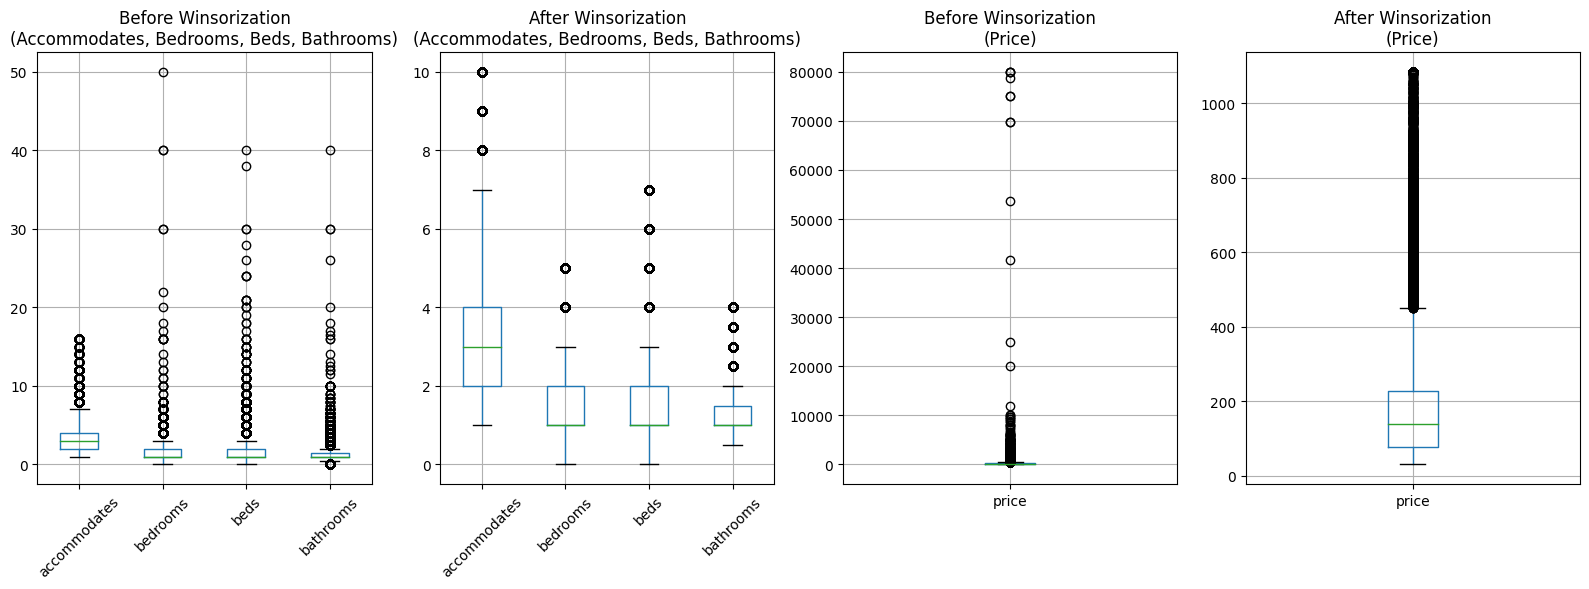

In [174]:
# Define columns to check
outlier_cols = ['accommodates', 'bedrooms', 'beds', 'bathrooms']

fig, axes = plt.subplots(1, 4, figsize=(16, 6))

# Boxplot BEFORE Winsorization (Multiple Features)
df_before_winsor[outlier_cols].boxplot(ax=axes[0])
axes[0].set_title("Before Winsorization\n(Accommodates, Bedrooms, Beds, Bathrooms)")
axes[0].tick_params(axis='x', rotation=45)

# Boxplot AFTER Winsorization (Multiple Features)
df[outlier_cols].boxplot(ax=axes[1])
axes[1].set_title("After Winsorization\n(Accommodates, Bedrooms, Beds, Bathrooms)")
axes[1].tick_params(axis='x', rotation=45)

# Boxplot BEFORE Winsorization (Price)
df_before_winsor[['price']].boxplot(ax=axes[2])
axes[2].set_title("Before Winsorization\n(Price)")
axes[2].tick_params(axis='x', rotation=0)

# Boxplot AFTER Winsorization (Price)
df[['price']].boxplot(ax=axes[3])
axes[3].set_title("After Winsorization\n(Price)")
axes[3].tick_params(axis='x', rotation=0)

# Adjust layout
plt.tight_layout()
plt.show()


In [175]:
df['log_price'] = np.log(df['price'])
df[['price', 'log_price']].describe()

,price,log_price
count,61364.000000,61364.000000
mean,188.032544,4.925346
std,176.304053,0.769227
min,30.000000,3.401197
25%,78.000000,4.356709
50%,138.000000,4.927254
75%,227.000000,5.424950
max,1084.000000,6.988413


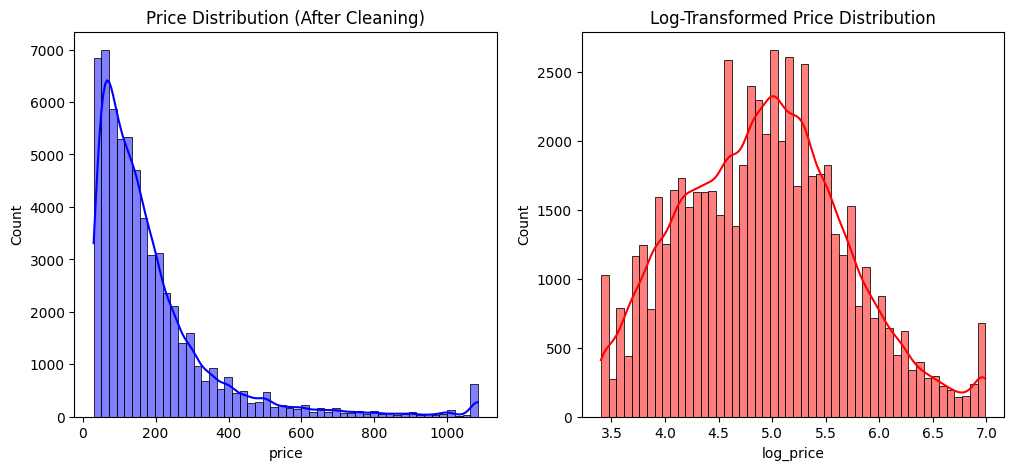

In [176]:
plt.figure(figsize=(12, 5))

# Original price distribution
plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=50, kde=True, color='blue')
plt.title("Price Distribution (After Cleaning)")

# Log-transformed price distribution
plt.subplot(1, 2, 2)
sns.histplot(df['log_price'], bins=50, kde=True, color='red')
plt.title("Log-Transformed Price Distribution")

plt.show()

/var/folders/zf/pq57_ly90s95938b__d76nbr0000gn/T/ipykernel_2960/3513887194.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df[correlation_features].corr()


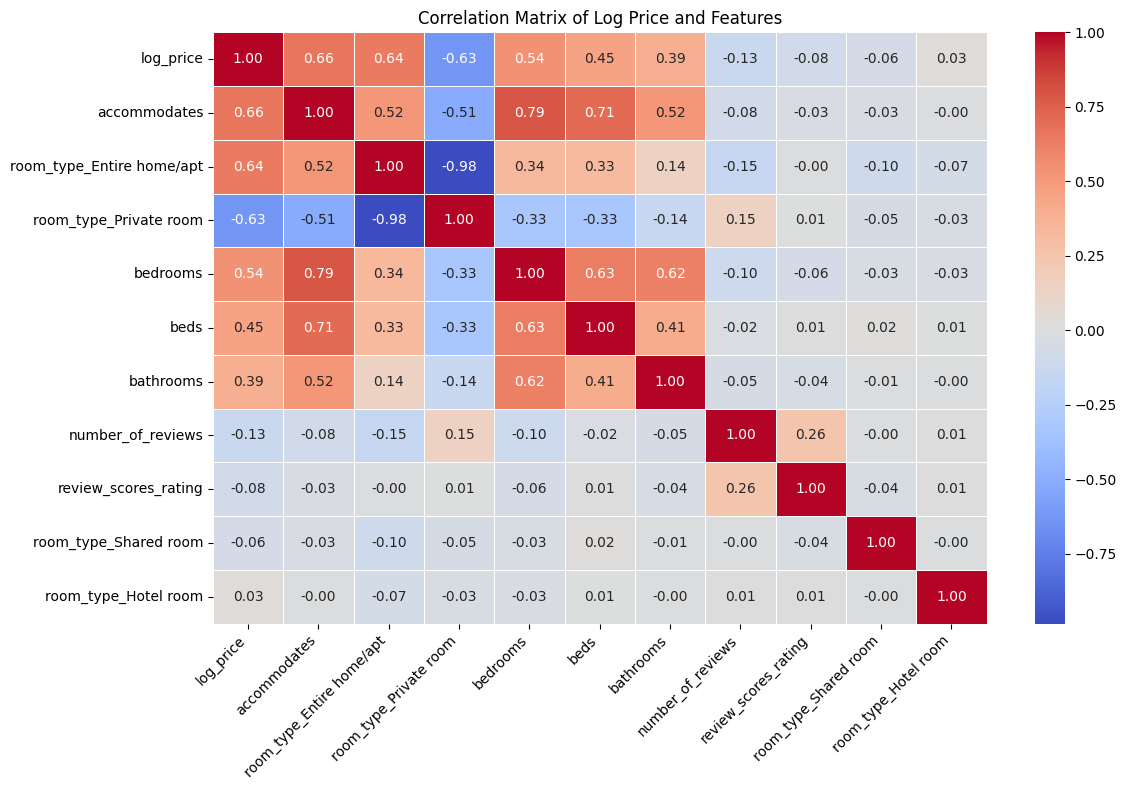

In [ ]:
# Compute correlation matrix including log_price
room_type_columns = [col for col in df.columns if col.startswith('room_type_')]
correlation_features = ['log_price', 'accommodates', 'bedrooms', 'beds', 
                        'bathrooms', 'number_of_reviews', 'review_scores_rating'] + room_type_columns

correlation_matrix = df[correlation_features].corr()

# Sort features based on their correlation with log_price
log_price_correlations = correlation_matrix['log_price'].drop('log_price')
sorted_features = log_price_correlations.abs().sort_values(ascending=False).index.tolist()

# Reorder correlation matrix with log_price first, followed by sorted features
ordered_features = ['log_price'] + sorted_features
ordered_correlation_matrix = correlation_matrix.loc[ordered_features, ordered_features]

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(ordered_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Log Price and Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# HERE IS THE COMMENT

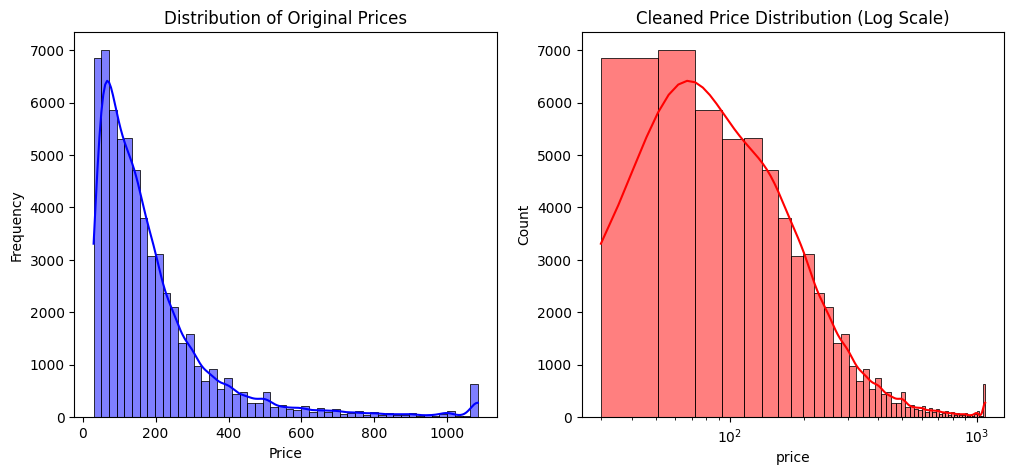

In [178]:
plt.figure(figsize=(12, 5))

# Original price distribution (log scale to fix overlap)
plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=50, kde=True, color='blue')
plt.title('Distribution of Original Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['price'], bins=50, kde=True, color='red')
plt.xscale('log')
plt.title("Cleaned Price Distribution (Log Scale)")

plt.show()

In [179]:
# Define numerical features to normalize
numerical_features = ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'number_of_reviews', 'review_scores_rating']

# Create a copy before normalization (to compare later)
df_original = df.copy()

# Initialize scaler
scaler = StandardScaler()

# Apply StandardScaler and store in new columns with "_normalized" suffix
df[[col + "_normalized" for col in numerical_features]] = scaler.fit_transform(df[numerical_features])

# Check transformation results
print(df[[col + "_normalized" for col in numerical_features]].describe())


       accommodates_normalized  bedrooms_normalized  beds_normalized  \
count             6.136400e+04         6.136400e+04     6.136400e+04   
mean             -6.669588e-17        -2.501096e-17    -5.187458e-17   
std               1.000008e+00         1.000008e+00     1.000008e+00   
min              -1.181581e+00        -1.621351e+00    -1.170240e+00   
25%              -6.856435e-01        -5.563137e-01    -4.499515e-01   
50%              -1.897062e-01        -5.563137e-01    -4.499515e-01   
75%               3.062310e-01         5.087234e-01     2.703371e-01   
max               3.281854e+00         3.703835e+00     3.871780e+00   

       bathrooms_normalized  number_of_reviews_normalized  \
count          6.136400e+04                  6.136400e+04   
mean          -1.954560e-16                 -1.713714e-17   
std            1.000008e+00                  1.000008e+00   
min           -1.379073e+00                 -4.431696e-01   
25%           -5.735691e-01                 -4

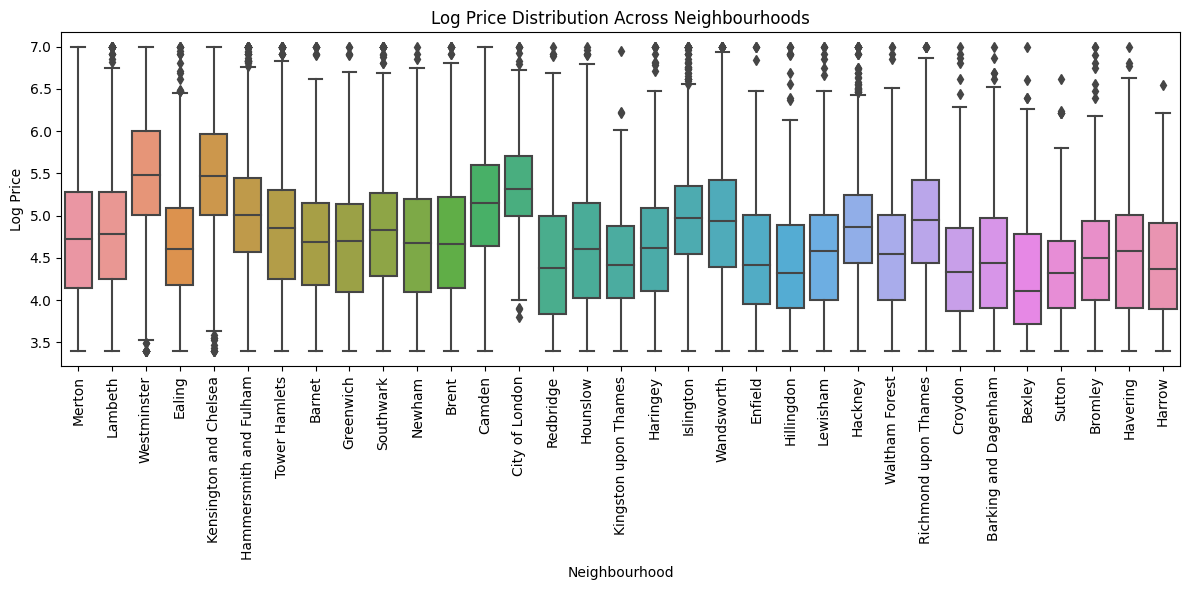

In [180]:
# Visualization: Price Across Neighborhoods
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='neighbourhood_original', y='log_price')
plt.xticks(rotation=90)
plt.title('Log Price Distribution Across Neighbourhoods')
plt.xlabel('Neighbourhood')
plt.ylabel('Log Price')
plt.tight_layout()
plt.show()

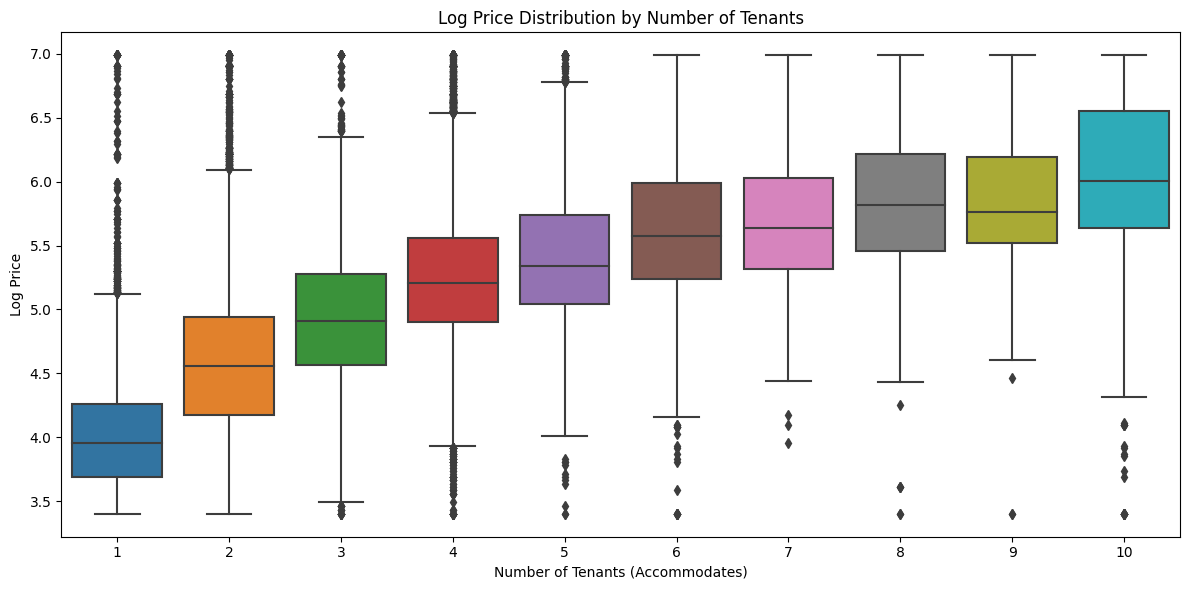

In [181]:
# Visualization: Price by Number of Tenants (Accommodates)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_original, x='accommodates', y='log_price')
plt.title('Log Price Distribution by Number of Tenants')
plt.xlabel('Number of Tenants (Accommodates)')
plt.ylabel('Log Price')
plt.tight_layout()
plt.show()

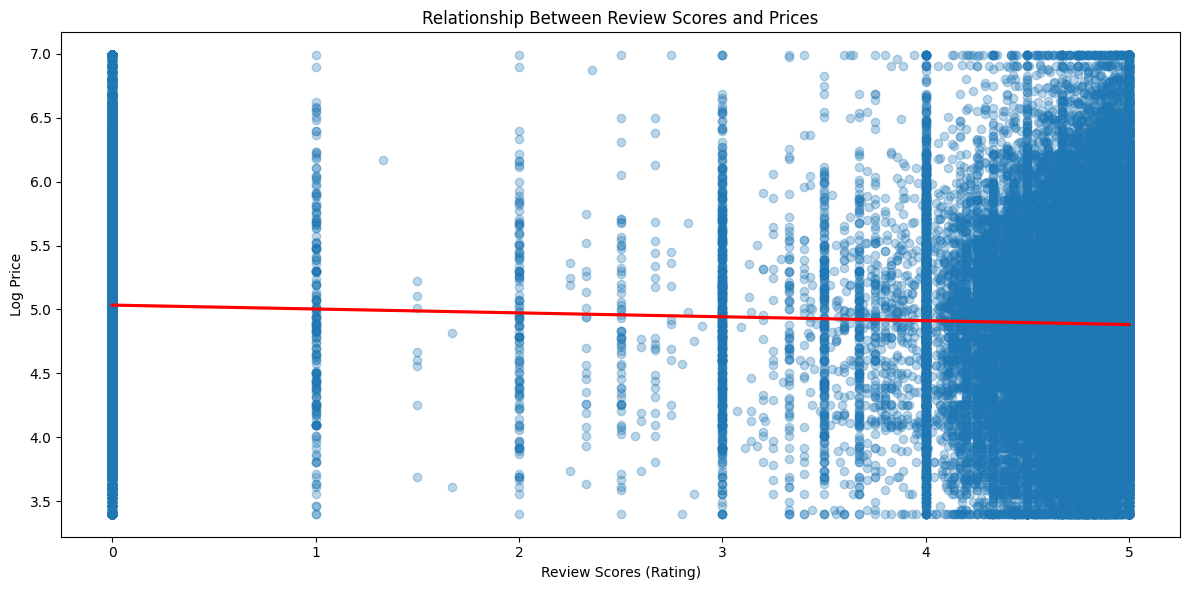

In [182]:
# Visualization: Relationship Between Review Scores and Prices
plt.figure(figsize=(12, 6))
sns.regplot(
    data=df_original,
    x='review_scores_rating',
    y='log_price',
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'}
)
plt.title('Relationship Between Review Scores and Prices')
plt.xlabel('Review Scores (Rating)')
plt.ylabel('Log Price')
plt.tight_layout()
plt.show()

In [183]:
# df.to_csv('CLEANED_DATASET_2.csv', index=False)

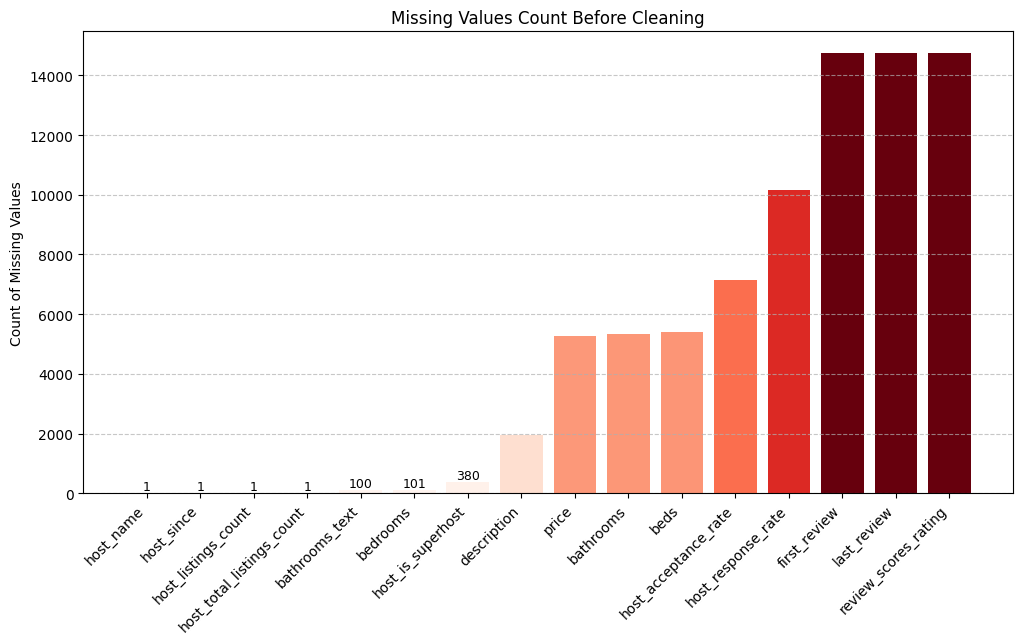

In [184]:
# Step 1: Sort missing values in ascending order
missing_values_before = df_first.isnull().sum()
missing_values_before = missing_values_before[missing_values_before > 0].sort_values()

# Step 2: Create bar plot with enhancements
plt.figure(figsize=(12, 6))
bars = plt.bar(missing_values_before.index, missing_values_before, color=plt.cm.Reds(missing_values_before / missing_values_before.max()))

# Step 3: Add labels for small values
for bar in bars:
    height = bar.get_height()
    if height < missing_values_before.max() * 0.1:  # Label only small values
        plt.text(bar.get_x() + bar.get_width()/2, height + 100, f'{int(height)}', ha='center', fontsize=9, color='black')

# Step 4: Format the graph
plt.title("Missing Values Count Before Cleaning")
plt.ylabel("Count of Missing Values")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


Create Linear Regression

In [185]:
from sklearn.model_selection import train_test_split

# features chosen to use for model
selected_features = ['accommodates', 'bedrooms', 'beds', 'log_price']  # Using 'log_price' instead of 'price_log'

# 
X = df[selected_features]
Y = df['price']  # Target variable

#  Split dataset into 80% training and 20% testing
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Training Set Shape:", trainX.shape, trainY.shape)
print("Testing Set Shape:", testX.shape, testY.shape)


Training Set Shape: (49091, 4) (49091,)
Testing Set Shape: (12273, 4) (12273,)


In [186]:
from sklearn.linear_model import LinearRegression

# Create Linear Regression model
model = LinearRegression()

# Train the model using training data
model.fit(trainX, trainY)

# Make predictions on the test set
predicted_prices = model.predict(testX)


In [187]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluate model performance
r2 = r2_score(testY, predicted_prices)
mse = mean_squared_error(testY, predicted_prices)
mae = mean_absolute_error(testY, predicted_prices)

'''
R² measues how well the model exlains variance
MSE Measures the average squared difference between predicted & actual values
MAE Measures the average absolute difference between predicted & actual values
'''

# Convert R² Score to percentage
r2_percentage = r2 * 100  

# Calculate MAE as a percentage of the mean actual price
mae_percentage = (mae / np.mean(testY)) * 100  

# Higher is better
print(f"R² Score: {r2:.4f} ({r2_percentage:.2f}%)")  

# Lower is better
print(f"MSE: {mse:.4f}")       
print(f"MAE: {mae:.4f} ({mae_percentage:.2f}% of average price)")  


R² Score: 0.7729 (77.29%)
MSE: 7283.7368
MAE: 56.6555 (30.07% of average price)


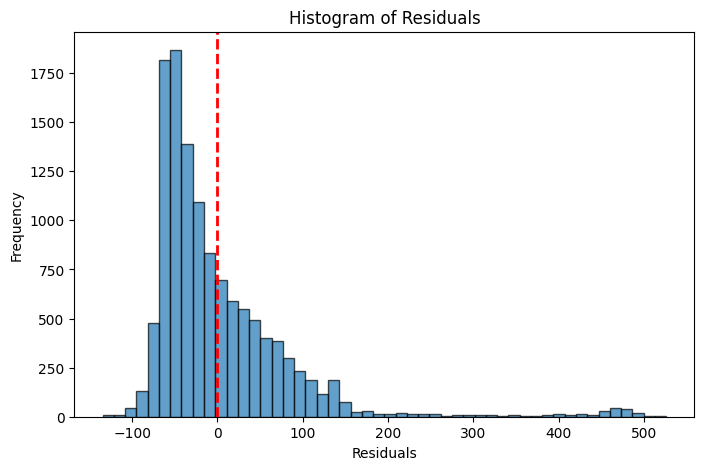

In [188]:
import matplotlib.pyplot as plt
import numpy as np

# Compute Residuals which measures the error between the model’s predictions and the real values
residuals = testY - predicted_prices

# Plot Histogram of Residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.axvline(x=0, color='red', linestyle='dashed', linewidth=2)
plt.show()


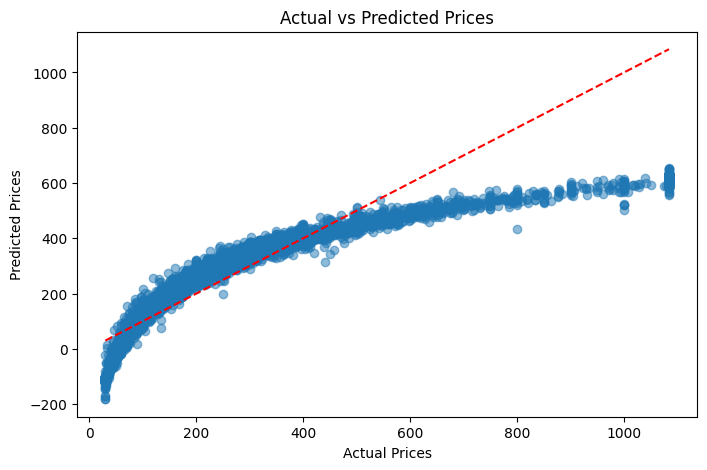

In [189]:
plt.figure(figsize=(8, 5))
plt.scatter(testY, predicted_prices, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.plot([min(testY), max(testY)], [min(testY), max(testY)], color='red', linestyle='dashed')  # Ideal fit line
plt.show()


Part 2

Part 2.1 K-mean clusters

In [190]:
print(df.columns.tolist())


['name', 'description', 'host_id', 'host_since', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'calculated_host_listings_count', 'neighbourhood_original', 'property_type_original', 'room_type_original', 'neighbourhood_Barking and Dagenham', 'neighbourhood_Barnet', 'neighbourhood_Bexley', 'neighbourhood_Brent', 'neighbourhood_Bromley', 'neighbourhood_Camden', 'neighbourhood_City of London', 'neighbourhood_Croydon', 'neighbourhood_Ealing', 'neighbourhood_Enfield', 'neighbourhood_Greenwich', 'neighbourhood_Hackney', 'neighbourhood_Hammersmith and Fulham', 'neighbourhood_Haringey', 'neighbourhood_Harrow', 'neighbourhood_Havering', 'neighbourhood_Hillingdon', 'neighbourhood_Hounslow', 'neighbourhood_Islington', 'neighbourhood_Kensington and Chelsea', 'neighbourhood_King

In [191]:
# Dropping columns that will not be used later on
drop_columns = [
    'name', 'description', 'host_id', 'host_since',
    'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
    'host_listings_count', 'host_total_listings_count',
    'accommodates_normalized', 'bedrooms_normalized', 'beds_normalized',
    'bathrooms_normalized', 'number_of_reviews_normalized',
    'review_scores_rating_normalized',
    'neighbourhood_original', 'property_type_original', 'room_type_original',
    'amenities'
]

df_cleaned = df.drop(columns=[col for col in drop_columns if col in df.columns])


In [192]:
# Identify encoded categorical columns
neighbourhood_columns = [col for col in df_cleaned.columns if col.startswith('neighbourhood_')]
room_type_columns = [col for col in df_cleaned.columns if col.startswith('room_type_')]

# Base numerical features 
selected_features = [
    'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'log_price', 'review_scores_rating'
]  + neighbourhood_columns + room_type_columns

# Build the dataset
df_selected = df_cleaned[selected_features].copy()

# Convert to numeric and handle missing values to use later
df_selected = df_selected.astype(float)
df_selected = df_selected.fillna(df_selected.mean())


In [193]:
# Remove neighbourhoods to simplify
df_simple = df_selected.drop(columns=neighbourhood_columns)

# This ensures that all features contribute equally to the distance calculations in KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_simple)


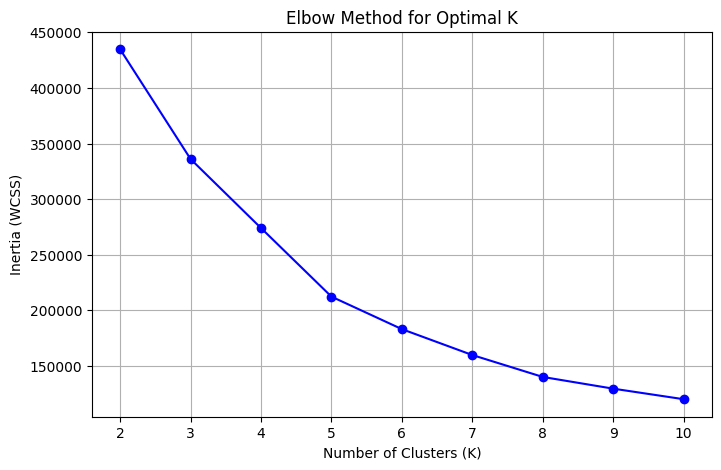

In [194]:
# This creates the elbow chart to determine the most optimal k value
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o', linestyle='-', color='blue')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()


In [195]:
# After using the chart we have gone with the value of 5 clusters
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_simple['cluster'] = kmeans.fit_predict(X_scaled)


In [196]:
from sklearn.cluster import KMeans

optimal_k = 5  # based on elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_selected['cluster'] = kmeans.fit_predict(X_scaled)

#Shows the size of each cluster
print(df_selected['cluster'].value_counts())


0    27879
3    19953
1    13117
2      282
4      133
Name: cluster, dtype: int64


In [197]:
# Allows for visualizing complex clusters in a 2D scatter plot
from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(data=principal_components, columns=['pca1', 'pca2'])
df_pca['cluster'] = df_simple['cluster'].values


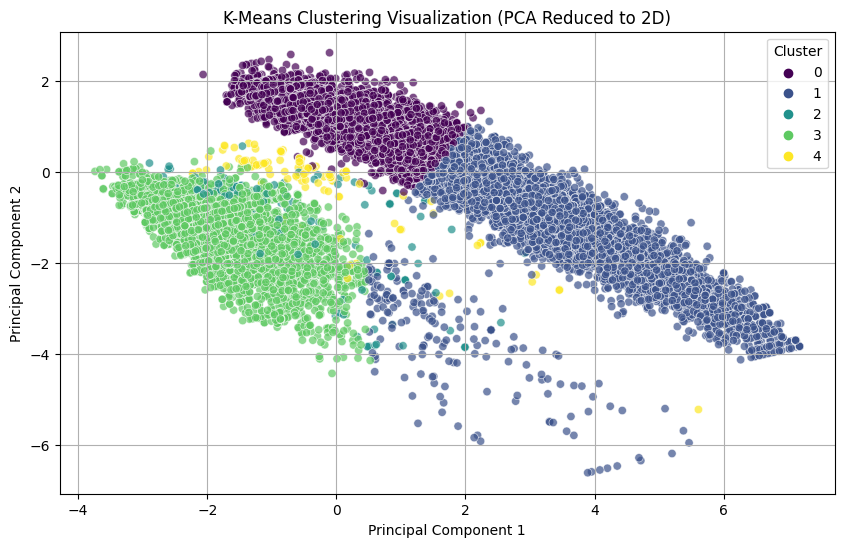

In [198]:
# Plots the KMeans clustering results in 2D using PCA components
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='pca1', y='pca2', hue='cluster', palette='viridis', alpha=0.7)

plt.title("K-Means Clustering Visualization (PCA Reduced to 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [199]:
##df_simple['cluster'] = df_selected['cluster'] 

# Summary per cluster
#df_simple.groupby('cluster').mean()


In [200]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd

# Select features (excluding log_price and cluster)
X_global = df_selected.drop(columns=['log_price', 'cluster'])
y_global = df_selected['log_price']  # Target variable 

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_global, y_global, test_size=0.2, random_state=42)


In [201]:
# Train the Linear Regression model
global_model = LinearRegression()
global_model.fit(X_train, y_train)

# Predict on test set
y_pred_global = global_model.predict(X_test)


In [202]:
# Evaluate model performance
mae_global = mean_absolute_error(y_test, y_pred_global)
r2_global = r2_score(y_test, y_pred_global)

# Print results
print(f"Global Regression Model - MAE: {mae_global:.2f}, R² Score: {r2_global:.2f}")


Global Regression Model - MAE: 0.33, R² Score: 0.68


In [203]:
# Initialize dictionaries to store model performance for comparison
cluster_models = {}
cluster_mae = {}
cluster_r2 = {}

# Loop through each cluster and train a separate model
for cluster_id in df_selected['cluster'].unique():
    print(f"\nTraining for Cluster {cluster_id}...")

    # Filter data for this specific cluster
    cluster_data = df_selected[df_selected['cluster'] == cluster_id]
    X_cluster = cluster_data.drop(columns=['log_price', 'cluster'])
    y_cluster = cluster_data['log_price']

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)

    # Train regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Evaluate performance
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    cluster_models[cluster_id] = model
    cluster_mae[cluster_id] = mae
    cluster_r2[cluster_id] = r2

    # pront results
    print(f"Cluster {cluster_id} - MAE: {mae:.4f}, R² Score: {r2:.4f}")



Training for Cluster 2...
Cluster 2 - MAE: 0.7277, R² Score: -0.1646

Training for Cluster 3...
Cluster 3 - MAE: 0.3250, R² Score: 0.2904

Training for Cluster 0...
Cluster 0 - MAE: 0.2974, R² Score: 0.3113

Training for Cluster 1...
Cluster 1 - MAE: 0.3202, R² Score: 0.4297

Training for Cluster 4...
Cluster 4 - MAE: 0.2791, R² Score: 0.7001


In [204]:
# Store regression results in a DataFrame
results_df = pd.DataFrame({
    "Cluster": list(cluster_mae.keys()),
    "MAE": list(cluster_mae.values()),
    "R² Score": list(cluster_r2.values())
})

# Add the Global Model for comparison
results_df.loc[len(results_df)] = ['Global Model', mae_global, r2_global]

# Display results
print(results_df)


        Cluster       MAE  R² Score
0             2  0.727704 -0.164650
1             3  0.325037  0.290400
2             0  0.297364  0.311308
3             1  0.320250  0.429720
4             4  0.279102  0.700139
5  Global Model  0.329400  0.677990


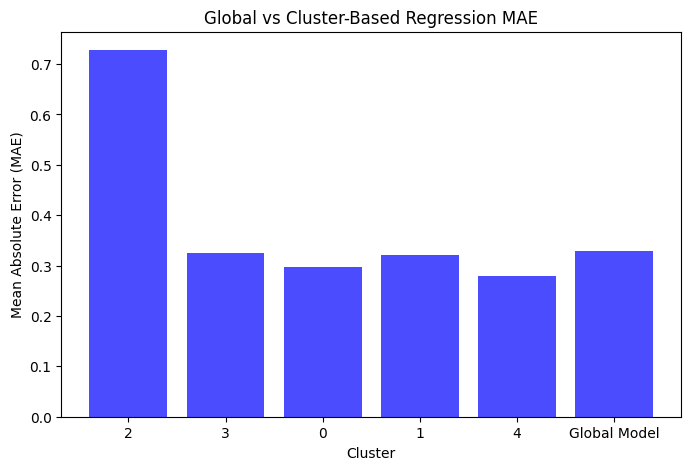

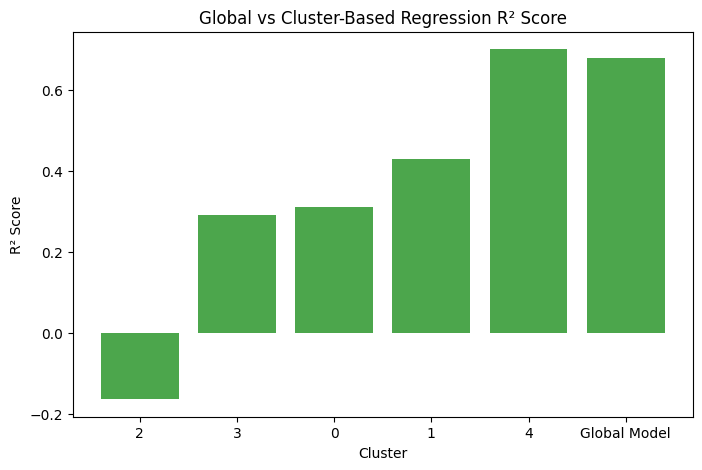

In [205]:
import matplotlib.pyplot as plt

# Plot comparison of MAE, lower the better
plt.figure(figsize=(8, 5))
plt.bar(results_df["Cluster"].astype(str), results_df["MAE"], color='blue', alpha=0.7)
plt.xlabel("Cluster")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Global vs Cluster-Based Regression MAE")
plt.show()

# Plot comparison of R² Score, lower the better
plt.figure(figsize=(8, 5))
plt.bar(results_df["Cluster"].astype(str), results_df["R² Score"], color='green', alpha=0.7)
plt.xlabel("Cluster")
plt.ylabel("R² Score")
plt.title("Global vs Cluster-Based Regression R² Score")
plt.show()


Improved model

In [206]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Select features and target variable 
X_rf = df_selected.drop(columns=['log_price', 'cluster']) 
y_rf = df_selected['log_price']  

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

# Display dataset shape
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")


Training data shape: (49091, 42), Test data shape: (12273, 42)


In [207]:
# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)


In [208]:
# Evaluate performance
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print results
print(f"Random Forest Regression - MAE: {mae_rf:.4f}, R² Score: {r2_rf:.4f}")

df.to_csv('CLEANED_DATASET_4.csv', index=False)


Random Forest Regression - MAE: 0.3307, R² Score: 0.6650


In [209]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Define the model
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - MAE: {mae_xgb:.4f}, R² Score: {r2_xgb:.4f}")


XGBoost - MAE: 0.3088, R² Score: 0.7110


In [210]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import numpy as np

# Define the model
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance on test set
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Perform 5-fold cross-validation for overall accuracy
cv_r2_scores = cross_val_score(xgb_model, X_train, y_train, scoring='r2', cv=5)
cv_mae_scores = cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)

# Convert negative MAE scores to positive
cv_mae_scores = -cv_mae_scores

# Compute mean and standard deviation for accuracy metrics
overall_r2_mean = np.mean(cv_r2_scores)
overall_r2_std = np.std(cv_r2_scores)
overall_mae_mean = np.mean(cv_mae_scores)
overall_mae_std = np.std(cv_mae_scores)

# Print results
print(f"XGBoost - Test Set MAE: {mae_xgb:.4f}, Test Set R² Score: {r2_xgb:.4f}")
print(f"Overall R² Score (Mean ± Std Dev): {overall_r2_mean:.4f} ± {overall_r2_std:.4f}")
print(f"Overall MAE (Mean ± Std Dev): {overall_mae_mean:.4f} ± {overall_mae_std:.4f}")


XGBoost - Test Set MAE: 0.3088, Test Set R² Score: 0.7110
Overall R² Score (Mean ± Std Dev): 0.7114 ± 0.0034
Overall MAE (Mean ± Std Dev): 0.3065 ± 0.0005


In [211]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import numpy as np

# Define the optimized model
optimized_xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)

# Train the model
optimized_xgb.fit(X_train, y_train)

# Make predictions
y_pred_optimized = optimized_xgb.predict(X_test)

# Evaluate performance on test set
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

# Convert R² Score to percentage
r2_optimized_percentage = r2_optimized * 100

# Perform 5-fold cross-validation for overall accuracy
cv_r2_scores_optimized = cross_val_score(optimized_xgb, X_train, y_train, scoring='r2', cv=5)
cv_mae_scores_optimized = cross_val_score(optimized_xgb, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)

# Convert negative MAE scores to positive
cv_mae_scores_optimized = -cv_mae_scores_optimized

# Compute mean and standard deviation for accuracy metrics
overall_r2_mean_optimized = np.mean(cv_r2_scores_optimized) * 100  # Convert to percentage
overall_r2_std_optimized = np.std(cv_r2_scores_optimized) * 100  # Convert to percentage
overall_mae_mean_optimized = np.mean(cv_mae_scores_optimized)
overall_mae_std_optimized = np.std(cv_mae_scores_optimized)

# Print final results with percentage accuracy
print(f"Optimized XGBoost - Test Set MAE: {mae_optimized:.4f}")
print(f"Optimized XGBoost - Test Set Accuracy (R² Score): {r2_optimized_percentage:.2f}%")
print(f"Overall Accuracy (R² Mean ± Std Dev): {overall_r2_mean_optimized:.2f}% ± {overall_r2_std_optimized:.2f}%")
print(f"Overall MAE (Mean ± Std Dev): {overall_mae_mean_optimized:.4f} ± {overall_mae_std_optimized:.4f}")


Optimized XGBoost - Test Set MAE: 0.3074
Optimized XGBoost - Test Set Accuracy (R² Score): 71.22%
Overall Accuracy (R² Mean ± Std Dev): 71.31% ± 0.37%
Overall MAE (Mean ± Std Dev): 0.3051 ± 0.0007


In [212]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Define an improved Neural Network model
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),  # More neurons
    layers.BatchNormalization(),  # Normalization
    layers.Dropout(0.3),  # Prevent overfitting

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(1)  # Output layer for price prediction
])

# Compile model with a reduced learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64)

# Evaluate model on the test set
mae_nn = model.evaluate(X_test, y_test)[1]
r2_nn = 1 - (mae_nn / np.mean(y_test))  # Approximate R² calculation

print(f"Neural Network MAE: {mae_nn:.4f}")
print(f"Neural Network Test Set Accuracy (R² Score): {r2_nn * 100:.2f}%")

# Cross-validation for overall percentage accuracy
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = []

for train_index, val_index in kf.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]


    model.fit(X_train_cv, y_train_cv, epochs=50, batch_size=64, verbose=0)
    mae_score = model.evaluate(X_val_cv, y_val_cv, verbose=0)[1]
    mae_scores.append(mae_score)

# Compute overall accuracy
overall_mae_mean = np.mean(mae_scores)
overall_r2_mean = 1 - (overall_mae_mean / np.mean(y_train))  # Approximate R² calculation

print(f"Overall MAE (Mean ± Std Dev): {overall_mae_mean:.4f} ± {np.std(mae_scores):.4f}")
print(f"Overall Accuracy (R² Mean): {overall_r2_mean * 100:.2f}%")


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
from sklearn.model_selection import KFold

# K-Fold Cross-Validation Setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = []

for train_index, val_index in kf.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

    model.fit(X_train_cv, y_train_cv, epochs=50, batch_size=64, verbose=0)
    mae_score = model.evaluate(X_val_cv, y_val_cv, verbose=0)[1]
    mae_scores.append(mae_score)

# Compute overall accuracy
overall_mae_mean = np.mean(mae_scores)
overall_r2_mean = 1 - (overall_mae_mean / np.mean(y_train))  # Approximate R² calculation

print(f"Overall MAE (Mean ± Std Dev): {overall_mae_mean:.4f} ± {np.std(mae_scores):.4f}")
print(f"Overall Accuracy (R² Mean): {overall_r2_mean * 100:.2f}%")
